# 1. 인물모드(shallow focus) 구현 및 실험

## 1) 구현

(492, 658, 3)


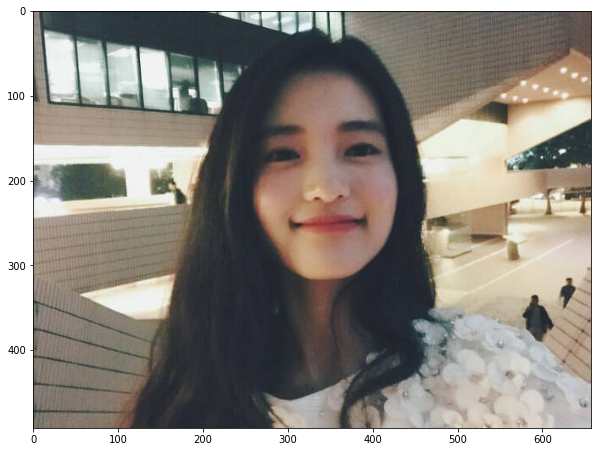

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

#img load
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/selfie_1.jpg'  
img_org = cv2.imread(img_path) 
print(img_org.shape)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))
plt.show()

In [2]:
import urllib
from pixellib.semantic import semantic_segmentation

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib download
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)
#load trained model
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)# pascal voc에 대해 훈련된 예외 모델 로드

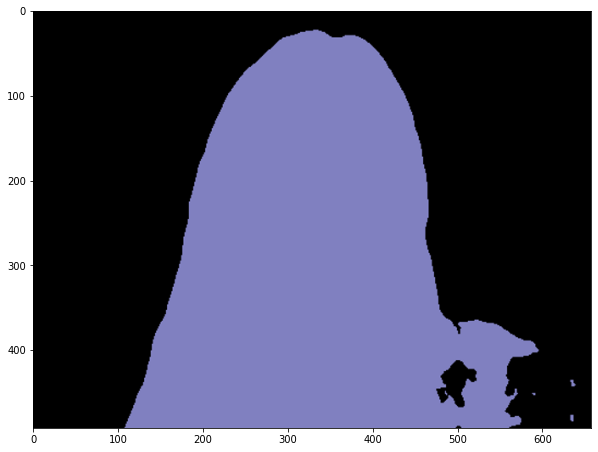

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [3]:
#adjust img segmetation
segvalues, output = model.segmentAsPascalvoc(img_path)
#output
plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show()
#segvalues
segvalues

In [4]:
#get class of segvalus
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [5]:
#get color of person class
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
print(colormap[:20])
print('person:',colormap[15])

[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]
person: [192 128 128]


(492, 658)


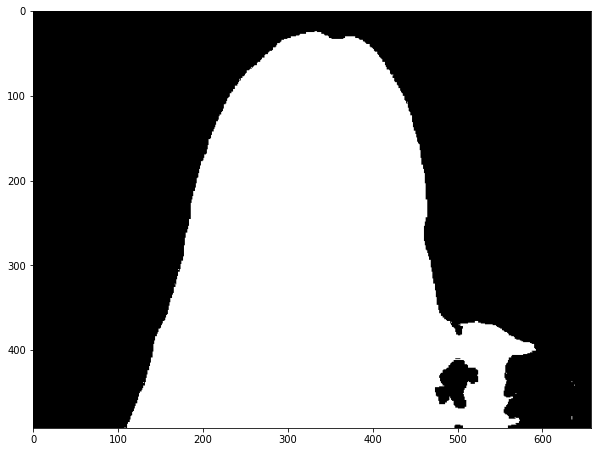

In [6]:
#get segmentation map of person class(T/F)
seg_color = (128,128,192) #colormap:rgb, output:bgr

seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.figure(figsize=(10,10))
plt.imshow(seg_map, cmap='gray')
plt.show()

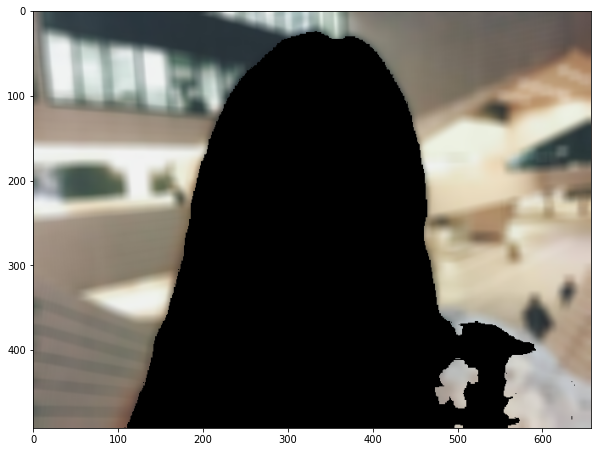

In [7]:
#blurring img
img_orig_blur = cv2.blur(img_org, (13,13))

# mask >> True = 255, False = 0
img_mask = seg_map.astype(np.uint8) * 255
img_mask_bgr = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# background mask >> background: 255, person: 0
img_bg_mask = cv2.bitwise_not(img_mask_bgr)

# blurring background >> blurred img + background mask
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

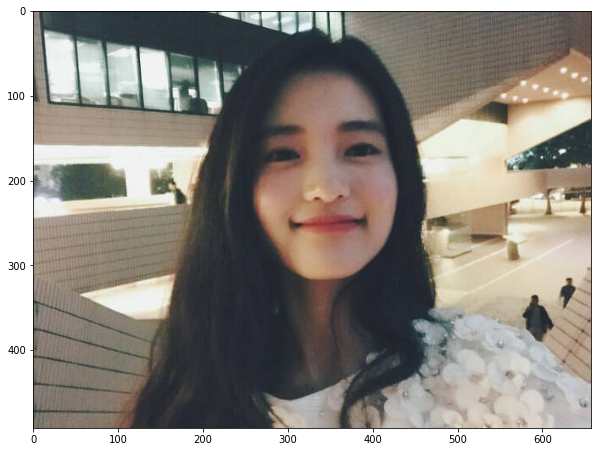

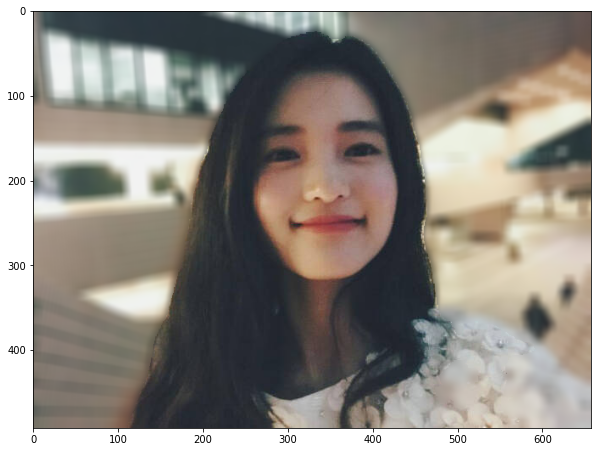

In [8]:
#img + blurred background
img_concat = np.where(img_mask_bgr==255, img_org, img_bg_blur)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

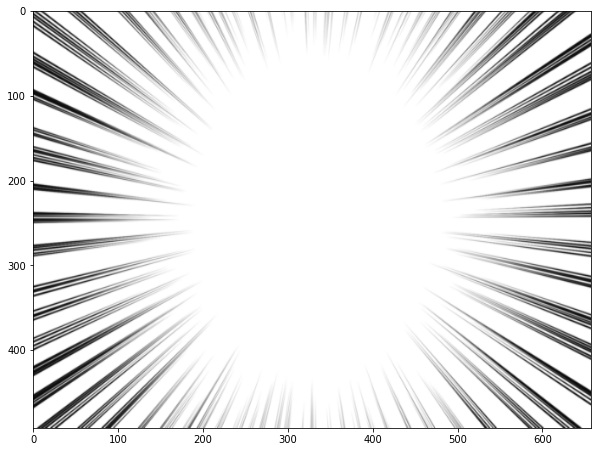

In [9]:
#chromakey load
chroma_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chroma_cartoon.png'
chroma_img = cv2.imread(chroma_path)
chroma_img_resize = cv2.resize(chroma_img, (img_org.shape[1],img_org.shape[0]))
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(chroma_img_resize, cv2.COLOR_BGR2RGB))
plt.show()

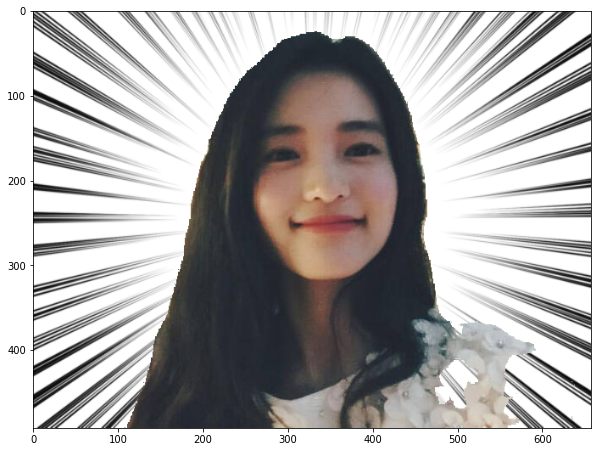

In [10]:
#chromakey applying
img_concat_chroma = np.where(img_mask_bgr==255, img_org, chroma_img_resize)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_concat_chroma, cv2.COLOR_BGR2RGB))
plt.show()

## 2) 다른 이미지 실험

In [11]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import urllib
from pixellib.semantic import semantic_segmentation

# Load trained segmentation model
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [12]:
## define blurring & chromakey function

#target class
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']

#class colormap
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
#blurring function
def apply_segmentation_mask(_img_path, _target_class):
    img = cv2.imread(_img_path)
    target_class = _target_class
    
    # Adjust image segmentation
    segvalues, output = model.segmentAsPascalvoc(_img_path)

    # Get class
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id],class_id)

    # Get segmentation map of target class (T/F)
    print('colormap: ',colormap[target_class])
    seg_color = (colormap[target_class][2], colormap[target_class][1], colormap[target_class][0])
    seg_map = np.all(output == seg_color, axis=-1)

    # Blurring image
    img_org_blur = cv2.blur(img, (30, 30))

    # Mask: True = 255, False = 0
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_bgr = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # Background mask: background: 255, target class: 0
    img_bg_mask = cv2.bitwise_not(img_mask_bgr)

    # Blurring background: blurred img + background mask
    img_bg_blur = cv2.bitwise_and(img_org_blur, img_bg_mask)

    # Image + blurred background
    img_concat = np.where(img_mask_bgr == 255, img, img_bg_blur)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1,3,2)
    plt.imshow(output)
    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return img_concat

#chromakey function
def apply_chromakey(_img_path, _target_class, _chroma_path):
    img = cv2.imread(_img_path)
    target_class = _target_class
    chroma_img = cv2.imread(chroma_path)
    chroma_img_resize = cv2.resize(chroma_img, (img.shape[1],img.shape[0]))
    
    segvalues, output = model.segmentAsPascalvoc(_img_path)

    # Get segmentation map of target class (255/0)
    seg_color = (colormap[target_class][2], colormap[target_class][1], colormap[target_class][0])
    seg_map = np.all(output == seg_color, axis=-1)
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_bgr = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    img_concat_chroma = np.where(img_mask_bgr==255, img, chroma_img_resize)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img_concat_chroma, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return img_concat_chroma

background 0
person 15
colormap:  [192 128 128]


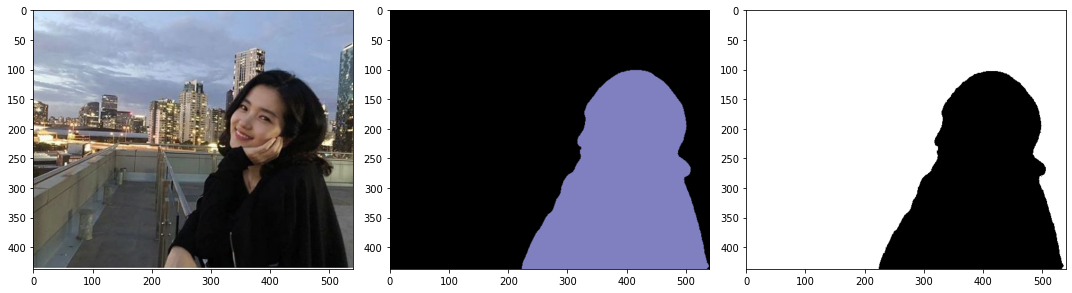

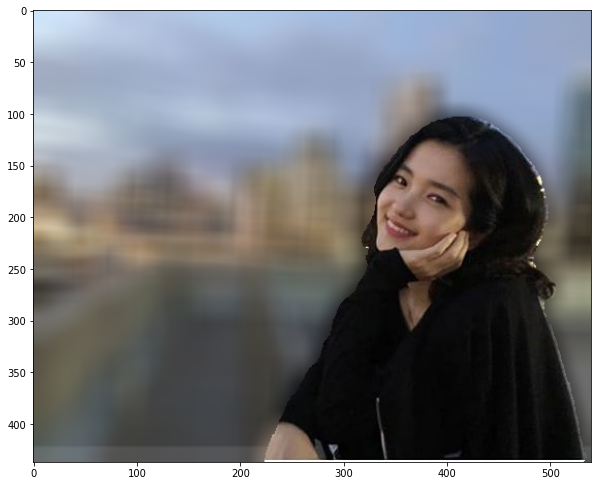

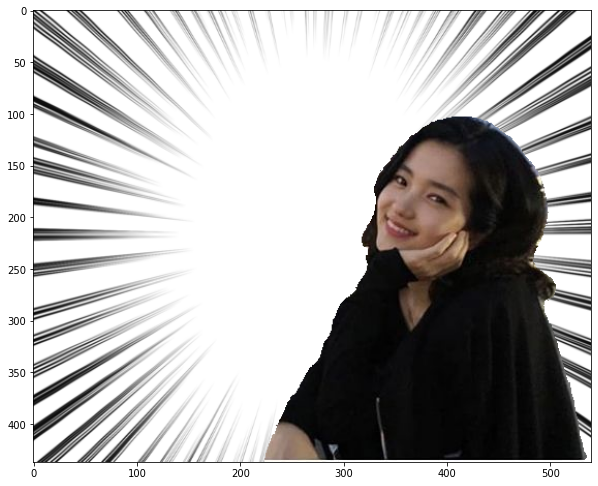

In [13]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/selfie_4.jpg'  
chroma_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chroma_cartoon.png'

blurred_img = apply_segmentation_mask(img_path, 15)
cromakey_img = apply_chromakey(img_path, 15, chroma_path)

background 0
bottle 5
cat 8
colormap:  [64  0  0]


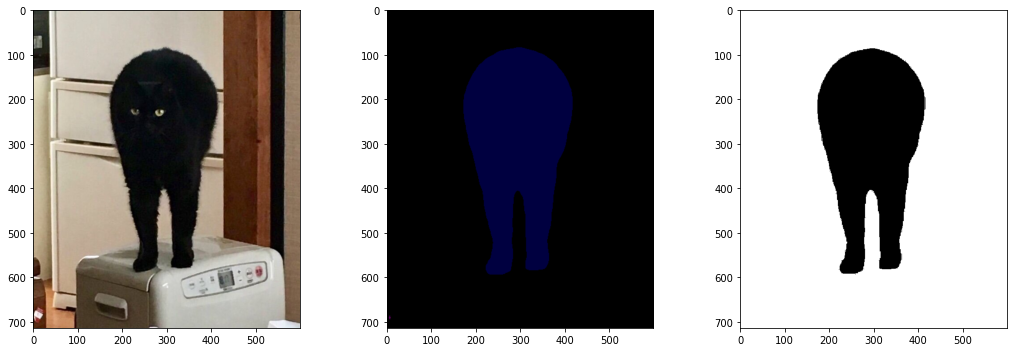

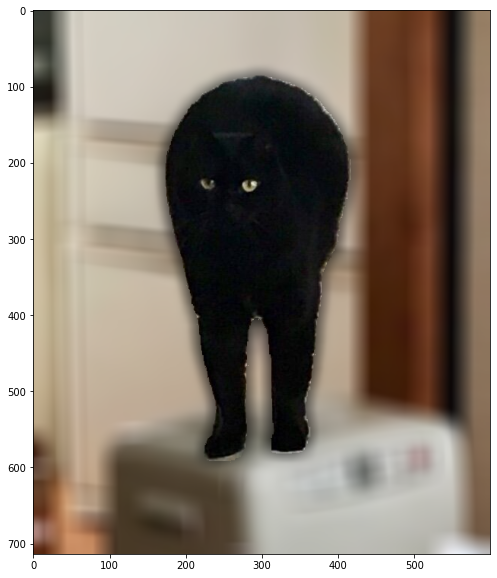

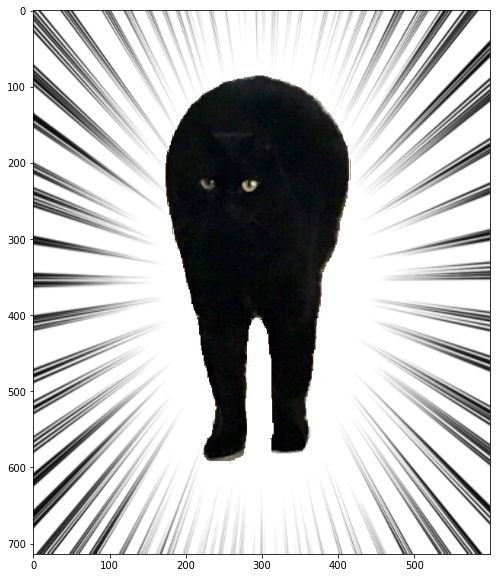

In [14]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_2.jpg'  
blurred_img = apply_segmentation_mask(img_path, 8)
cromakey_img = apply_chromakey(img_path, 8, chroma_path)

background 0
cat 8
colormap:  [64  0  0]


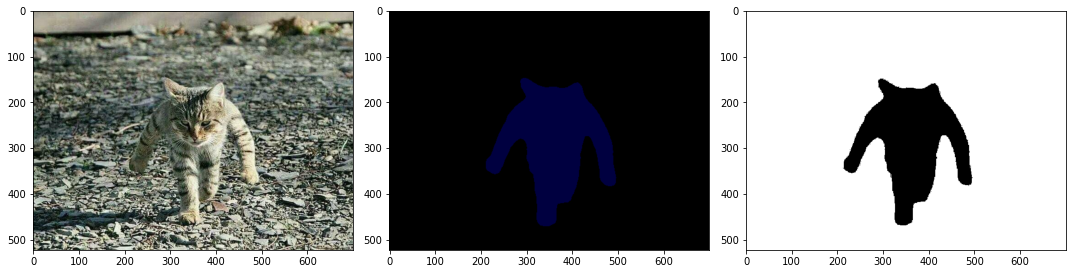

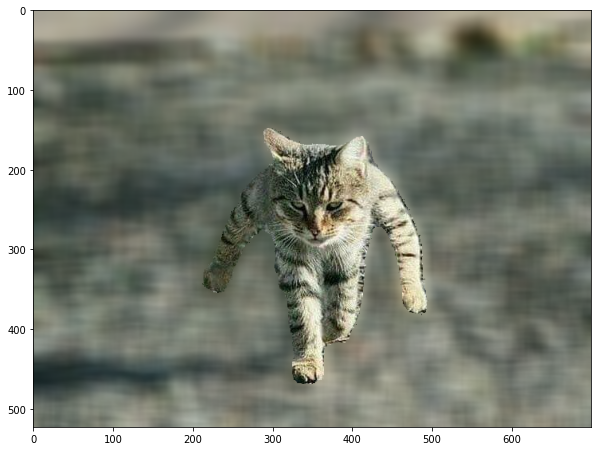

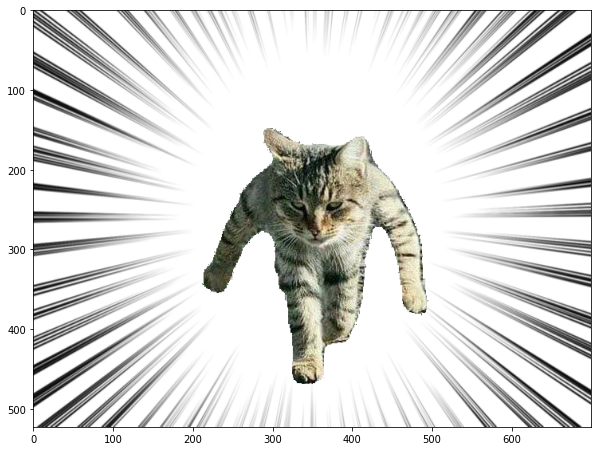

In [15]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_3.jpg'  
blurred_img = apply_segmentation_mask(img_path, 8)
cromakey_img = apply_chromakey(img_path, 8, chroma_path)

background 0
horse 13
person 15
colormap:  [192 128 128]


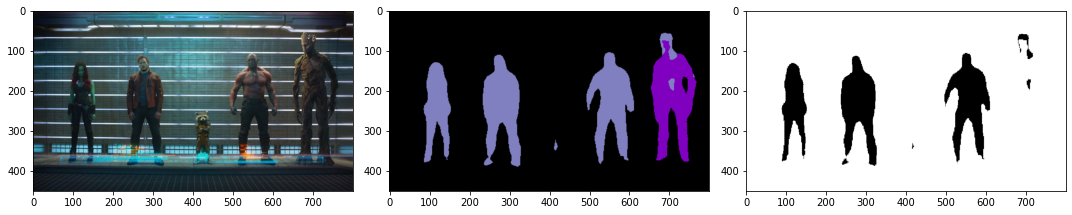

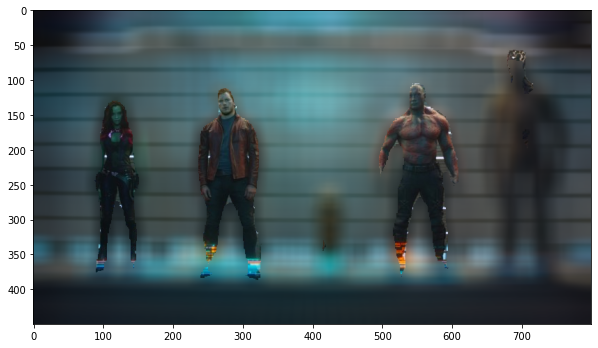

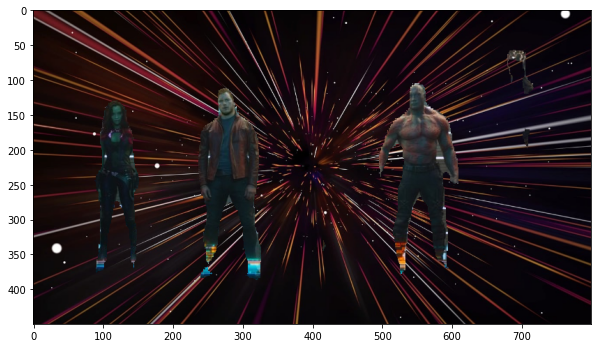

In [16]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/gog_1.jpg'  
chroma_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chroma_warp.jpg'
blurred_img = apply_segmentation_mask(img_path, 15)
cromakey_img = apply_chromakey(img_path, 15, chroma_path)

# 2. 문제점 및 해결방안 제안

In [17]:
from IPython.display import Image

## 1) 세그멘테이션의 한계
    
![walking cat](./images/cat_3_blur.png "walking cat")

- 셸로우 포커싱을 인위적으로 구현하기 위해, 인물/배경 두가지로 세그멘테이션을 하고, 인물을 초점거리에 있는 것처럼 보이도록 배경에 블러 효과를 적용한다.
- 실제로는 초점에서 멀어질수록 흐리게 보이는 정도가 다르기 때문에, 부자연스러운 결과가 나온다.

> 제안 : 블러 효과를 조정할 파라미터 적용
>    - 인물/배경의 T/F mask와 blurring mask window의 합성곱 연산값 > window가 인물을 얼마나 포함하는지
>    - 인물의 중앙을 정하고(bounding box 중앙 + 이미지의 중앙) 초점이라 가정 후, 픽셀간 거리 계산 

- depth 예측 모델이나 여러 센서를 통해 거리를 직접 계산할 수 있는 데이터를 이용할 수 있을 것 같다.   
     ex)struct2Depth - Google   

## 2) 모델의 한계
    
![Tae-ri](./images/sefie_1_blur_err.png)
![gog](./images/gog_1_seg_err.png)

- 빨간색 박스 : 일부 픽셀에서 배경으로 예측
> 제안:  1. object dection 결과를 통해 유효범위를 늘릴 수 있을 것 같다. ex)bounding box내 픽셀에 해당 클래스 가중치 부여   
>  2. 주변 픽셀값의 유사도를 계산해서 유사도가 높은 픽셀의 클래스를 반영
- 파란색 박스 : 클래스 예측 실패
> 제안: 클래스 종류 및 데이터를 늘려서 학습
- 초록색 박스 : 이유모를 예측
> 제안: object dection으로 걸러낼 수 있을 것 같다.

- 더 나은 segmentation 성능을 보이는 최신 모델을 구현하는 것이 좋아보인다. ex)Segment Anything - Meta AI